<a href="https://colab.research.google.com/github/0606Yeh/CNN-Assignment-2025/blob/ACS110114/ACS110114_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# CNN Classroom Exercise: Image Classification with CIFAR-10
# Objective: Practice building, training, and evaluating a CNN using TensorFlow/Keras
# Environment: Google Colab with GPU
# Dataset: CIFAR-10 (10 classes of 32x32 color images)

# Import Libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

In [26]:
# GPU 設置 - 避免 cuDNN 初始化錯誤
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 設置 GPU 記憶體增長
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        details = tf.config.experimental.get_device_details(gpu)
        print(f"詳細信息: {details}")
        print(f"Found {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU 設置錯誤: {e}")
else:
    print("沒有找到 GPU，使用 CPU 進行訓練")

詳細信息: {'compute_capability': (8, 9), 'device_name': 'NVIDIA GeForce RTX 4080 SUPER'}
Found 1 GPU(s)


2025-06-17 00:14:51.435342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [27]:
# Load and Preprocess CIFAR-10 Dataset
# CIFAR-10 contains 60,000 32x32 color images in 10 classes (e.g., airplane, cat, dog)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

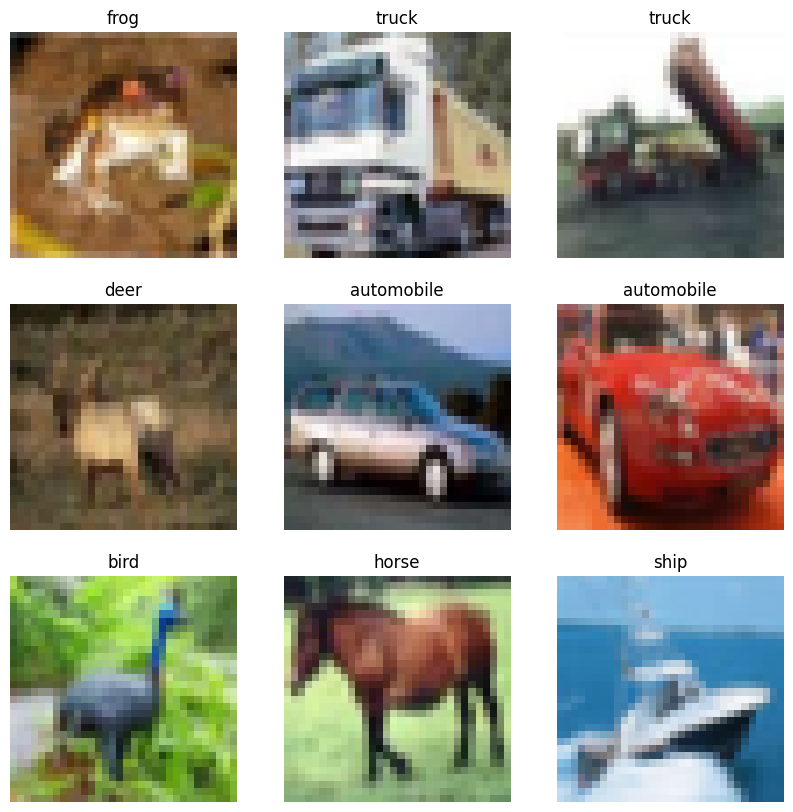

In [28]:
# Visualize Sample Data: 
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()

# Task 1: Model Architecture Enhancement

In [29]:
# Build the CNN Model
model = models.Sequential([
    # First Convolutional Block - 增加filters
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # 大幅降低dropout
    
    # Second Convolutional Block - 更多filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    # Third Convolutional Block - 增加深度
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Fourth Convolutional Block - 更多特徵
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    
    # Dense Layers - 更多參數
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    
    # Output Layer
    layers.Dense(10, activation='softmax')
])
# Display model summary
model.summary()

/home/ntcucsk201/anaconda3/envs/mahjong/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             

 Total params: 5,879,370 (22.43 MB)

 Trainable params: 5,874,378 (22.41 MB)

 Non-trainable params: 4,992 (19.50 KB)

# Task 2: Hyperparameter Optimization

In [30]:
# Compile the Model
initial_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Task3: Data Augmentation

In [31]:
datagen = ImageDataGenerator(
    rotation_range=10,        # 減少旋轉角度 (原15)
    width_shift_range=0.05,   # 減少位移 (原0.1)
    height_shift_range=0.05,  # 減少位移 (原0.1)
    horizontal_flip=True,     # 保持水平翻轉
    zoom_range=0.05,          # 減少縮放 (原0.1)
    fill_mode='nearest'
)
datagen.fit(train_images)

In [32]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # 增加patience
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [33]:
# Train the Model
history = model.fit(
                train_images, train_labels, batch_size=16,
                # datagen.flow(train_images, train_labels, batch_size=128),
                steps_per_epoch=len(train_images) // 16, 
                epochs=50, 
                validation_data=(test_images, test_labels),
                callbacks=callbacks,
                verbose=1)


Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2675 - loss: 2.1553 - val_accuracy: 0.5297 - val_loss: 1.2959 - learning_rate: 0.0010
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5460 - loss: 1.2824 - val_accuracy: 0.5360 - val_loss: 1.3988 - learning_rate: 0.0010
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6481 - loss: 1.0192 - val_accuracy: 0.6118 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7207 - loss: 0.8285 - val_accuracy: 0.6557 - val_loss: 1.0630 - learning_rate: 0.0010
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7661 - loss: 0.7072 - val_accuracy: 0.7568 - val_loss: 0.7174 - learning_rate: 0.0010
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7989 - loss: 0.6066 - val_accuracy: 0.8018 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8278 - 

In [34]:
# Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")


313/313 - 1s - 3ms/step - accuracy: 0.8810 - loss: 0.7034

Test accuracy: 0.8810


# Task 4: Visualization

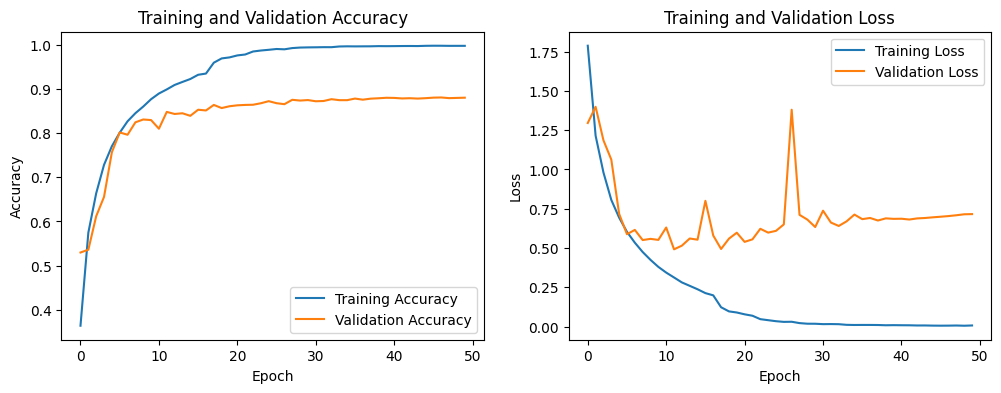

In [35]:

# Step 8: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
# Make Predictions
predictions = model.predict(test_images[:5])
for i in range(5):
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[test_labels[i][0]]
    print(f"Image {i+1}: Predicted: {predicted_label}, True: {true_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Image 1: Predicted: cat, True: cat
Image 2: Predicted: ship, True: ship
Image 3: Predicted: ship, True: ship
Image 4: Predicted: airplane, True: airplane
Image 5: Predicted: frog, True: frog


In [37]:
# Step 10: Save Model Performance for Autograding
# This cell saves the model performance to a text file for GitHub Actions
try:
    # Get final training accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Create performance summary
    performance_text = f"""Model Performance Summary:
Test Accuracy: {test_acc:.4f}
Test Loss: {test_loss:.4f}
Final Training Accuracy: {final_train_acc:.4f}
Final Validation Accuracy: {final_val_acc:.4f}
Final Training Loss: {final_train_loss:.4f}
Final Validation Loss: {final_val_loss:.4f}
Training Epochs: {len(history.history['accuracy'])}
Model Parameters: {model.count_params()}"""

    # Save to file for GitHub Actions
    with open('model_accuracy.txt', 'w') as f:
        f.write(performance_text)

    print("Model performance saved to model_accuracy.txt")
    print(performance_text)

except Exception as e:
    print(f"Error saving model performance: {e}")
    # Create a basic file even if there's an error
    with open('model_accuracy.txt', 'w') as f:
        f.write(f"Model execution completed with errors: {e}")

Model performance saved to model_accuracy.txt
Model Performance Summary:
Test Accuracy: 0.8810
Test Loss: 0.7034
Final Training Accuracy: 0.9980
Final Validation Accuracy: 0.8805
Final Training Loss: 0.0072
Final Validation Loss: 0.7160
Training Epochs: 50
Model Parameters: 5879370


# Task 5:
- 硬體強化：使用GPU加速訓練
- 數據強化：使用三種程度的數據增強，動態生成更多訓練樣本
    - 數據增強
    - 輕量級數據增強 
    - 漸進式數據增強  
->但結果都會導致梯度爆炸，準確率起伏高，且結果較差
- 複雜化模型：四層卷積層，以及增加filter數量
- 全局平均池化：相比 Flatten 更能減少參數
- Dropout：加入Dropout避免overfitting
- 自適應學習率：訓練過程中動態調整學習率
- 訓練優化：Early Stopping 以防止過度訓練  
**結論**：從accurancy 69% -> 88%
